In [2]:
from pdf2image import convert_from_path
import cv2
from pathlib import Path
import pytesseract
import json
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt


pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

path_to_poppler_exe = Path(r"D:\poppler-utils\poppler-24.02.0\Library\bin")

In [66]:
pdf_path = r"D:\OCR\2024-EROLLGEN-S15-41-FinalRoll-Revision1-ENG-1-WI.pdf"

images = convert_from_path(pdf_path, poppler_path=path_to_poppler_exe,first_page=3, last_page=16)

print(len(images))

14


In [67]:
np_images = [cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR) for image in images]

In [13]:
test_img_path = r"D:\OCR\ocr_test_page_page-0001.jpg"

In [6]:
def show_img(np_img):
    plt.imshow(np_img,cmap='gray')
    plt.show()

In [7]:
def show_img_full(img):
    cv2.imshow('Test Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [40]:
def enhance_image(original_image):    
    original_img = np_images[0]
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    #blurred_img = cv2.GaussianBlur(gray_img, (3,3), 0)
    _, threshold_image = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    enhanced_image = cv2.equalizeHist(threshold_image)
    return enhanced_image

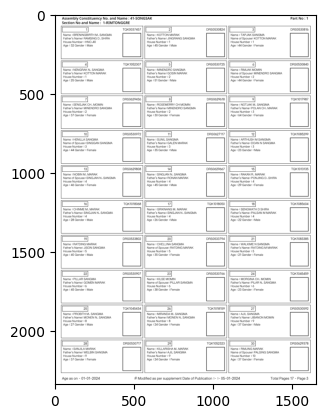

In [68]:
gray_img = cv2.cvtColor(np_images[0], cv2.COLOR_BGR2GRAY)
show_img(gray_img)

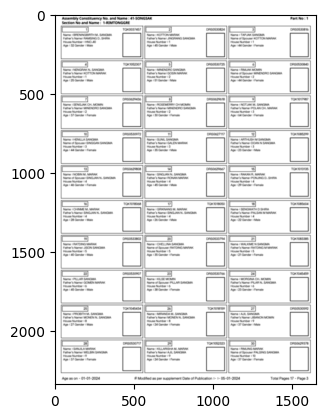

In [69]:
blurred_img = cv2.GaussianBlur(gray_img, (11,11), 0)
show_img(blurred_img)

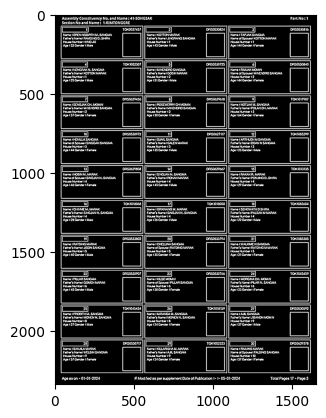

In [79]:
thresh = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
show_img(thresh)

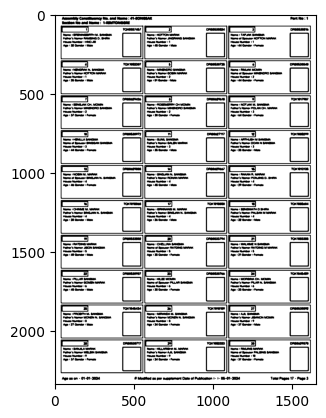

In [70]:
_, threshold_image = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show_img(threshold_image)

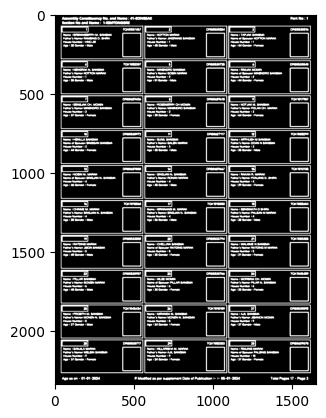

In [71]:
inverted_img = cv2.bitwise_not(threshold_image)
show_img(inverted_img)

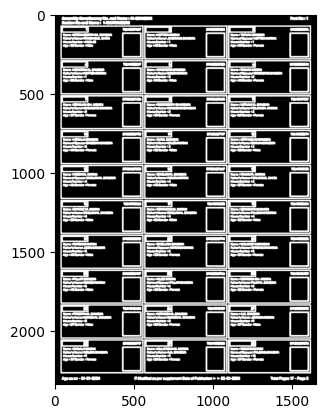

In [73]:
kernel = np.ones((5,5),np.uint8)
dilated_img = cv2.dilate(inverted_img, kernel, iterations = 1)
show_img(dilated_img)

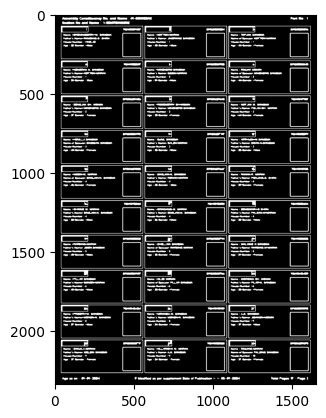

In [74]:
kernel = np.ones((7,7), np.uint8)
eroded_img = cv2.erode(dilated_img, kernel, iterations = 1)
show_img(eroded_img)

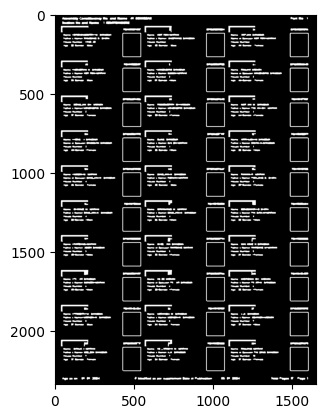

In [75]:
kernel = np.ones((5,5),np.uint8)
opening_img = cv2.morphologyEx(eroded_img, cv2.MORPH_OPEN, kernel)
show_img(opening_img)

In [76]:
new_img = eroded_img - opening_img
show_img_full(new_img)

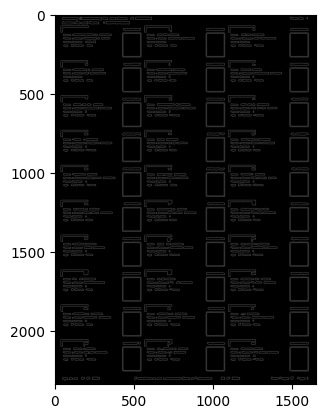

In [20]:
canny_img = cv2.Canny(opening_img,100,255)
show_img(canny_img)

In [95]:
area = 0
for c in contours:
    area += cv2.contourArea(c)
avg_area = area/30
print(avg_area)
print(cv2.contourArea(contours[15]))

113481.85
113187.0


In [97]:
contours,_ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_contour_area = 90000
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
tolerance = 5
contours = sorted(contours, key=lambda cnt: (round(cv2.boundingRect(cnt)[1]), round(cv2.boundingRect(cnt)[0], tolerance)))

#bounding_boxes = sorted([cv2.boundingRect(c) for c in contours], key=lambda b: (b[0], b[1]), reverse=True)
print(len(contours))
print(contours)

30
[array([[[ 36,  71]],

       [[ 35,  72]],

       [[ 35,  73]],

       [[ 34,  74]],

       [[ 34, 285]],

       [[ 35, 286]],

       [[ 35, 287]],

       [[ 36, 287]],

       [[ 37, 288]],

       [[ 43, 288]],

       [[ 44, 287]],

       [[548, 287]],

       [[549, 288]],

       [[556, 288]],

       [[557, 287]],

       [[558, 287]],

       [[558, 286]],

       [[559, 285]],

       [[559, 279]],

       [[558, 278]],

       [[558,  80]],

       [[559,  79]],

       [[559,  74]],

       [[558,  73]],

       [[558,  72]],

       [[557,  71]],

       [[547,  71]],

       [[546,  72]],

       [[ 46,  72]],

       [[ 45,  71]]], dtype=int32), array([[[ 564,   71]],

       [[ 562,   73]],

       [[ 562,  286]],

       [[ 563,  287]],

       [[ 564,  287]],

       [[ 565,  288]],

       [[ 571,  288]],

       [[ 572,  287]],

       [[1078,  287]],

       [[1079,  288]],

       [[1084,  288]],

       [[1085,  287]],

       [[1086,  287]],

       [[1

In [85]:
def draw_contours(image, contours):
    # Draw the contours on a copy of the original image
    result_image = image.copy()
    cv2.drawContours(result_image, contours, -1, (0, 255, 0), 2)

    return result_image

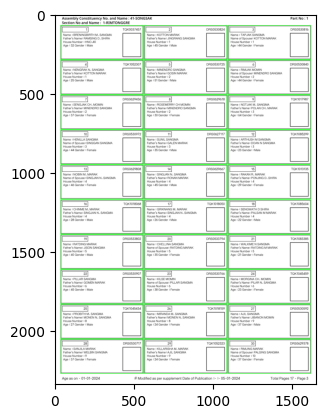

In [98]:
extraction_img = np_images[0]
contour_img = draw_contours(extraction_img, contours)
show_img(contour_img)

In [46]:
_, binary_image = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [47]:
enhanced_image = cv2.equalizeHist(binary_image)

In [99]:
ocr_text = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
            
    ROI = np_images[0][y:y+h, x:x+w]
    text = pytesseract.image_to_string(ROI, config=r"--oem 3 --psm 11") #, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
    ocr_text.append(text)

print(len(ocr_text))

30


In [100]:
print(ocr_text[:5])

["TQK0037457\n\nLC\n\nName : BRENINGBIRTH M. SANGMA\n\nFather's Name: RAMSING D. SHIRA\n\nHouse Number : HNO.40\n\nAge + 32 Gender : Male\n", "DRS0530824\n\nC2\n\nName : KOTTON MARAK\n\nFather's Name: JINGRANG SANGMA\n\nHouse Number : 1\n\nAge : 45 Gender : Male\n", 'DRS0530816\n\nName : TAPJAK SANGMA\n\nName of Spouse: KOTTON MARAK\n\nHouse Number : 1\n\nAge : 44 Gender : Female\n', "TQK1052307\n\nName : NENGRAK N. SANGMA\n\nFather's Name: KOTTON MARAK\n\nHouse Number :1\n\nAge : 25 Gender : Male\n", "ORS0530725\n\nName : MINENDRO SANGMA\n\nFather's Name: GOSIN MARAK\n\nHouse Number +2\n\nAge : 51 Gender : Male\n"]


In [60]:
### Stricter Regex

output_dict = dict()

for index, text in enumerate(ocr_text):

    unique_id_match = re.search(r'\b[A-Z]+\d+\b', text)
    unique_id = unique_id_match.group() if unique_id_match else None
    
    name_match = re.search(r'Name\s*:\s*([A-Z\s.]+)', text)
    name = name_match.group(1).split('\n', 1)[0].strip() if name_match else None

    father_name_match = re.search(r"Father's\s+Name\s*:\s*([A-Z\s.]+)", text)
    father_name = father_name_match.group(1).split('\n', 1)[0].strip() if father_name_match else None
    
    spouse_name_match = re.search(r"Name\s+of\s+Spouse\s*:\s*([A-Z\s.]+)", text)
    spouse_name = spouse_name_match.group(1).split('\n', 1)[0].strip() if spouse_name_match else None
    
    house_number_match = re.search(r'House\s+Number\s*:\s*(\d+)', text)
    house_number = house_number_match.group(1).strip() if house_number_match else None
    
    age_match = re.search(r'Age\s*:\s*(\d+)', text)
    age = age_match.group(1).strip() if age_match else None
    
    gender_match = re.search(r'Gender\s*:\s*(Male|Female)', text)
    gender = gender_match.group(1).strip() if gender_match else None

    # Creating dictionary
    output_dict[index+1] = {
        "unique_id": unique_id,
        "Name": name,
        "Father's Name": father_name,
        "Name of Spouse": spouse_name,
        "House Number": house_number,
        "Age": age,
        "Gender": gender
    }

with open("ocr_test04", 'w') as f:
    json.dump(output_dict, f)

print(output_dict)


{1: {'unique_id': 'TQK0037457', 'Name': 'BRENINGBIRTH M. SANGMA', "Father's Name": 'RAMSING D. SHIRA', 'Name of Spouse': None, 'House Number': None, 'Age': None, 'Gender': 'Male'}, 2: {'unique_id': 'DRS0530824', 'Name': 'KOTTON MARAK', "Father's Name": 'JINGRANG SANGMA', 'Name of Spouse': None, 'House Number': '1', 'Age': '45', 'Gender': 'Male'}, 3: {'unique_id': 'DRS0530816', 'Name': 'TAPJAK SANGMA', "Father's Name": None, 'Name of Spouse': 'KOTTON MARAK', 'House Number': '1', 'Age': '44', 'Gender': 'Female'}, 4: {'unique_id': 'TQK1052307', 'Name': 'NENGRAK N. SANGMA', "Father's Name": 'KOTTON MARAK', 'Name of Spouse': None, 'House Number': '1', 'Age': '25', 'Gender': 'Male'}, 5: {'unique_id': 'ORS0530725', 'Name': 'MINENDRO SANGMA', "Father's Name": 'GOSIN MARAK', 'Name of Spouse': None, 'House Number': None, 'Age': '51', 'Gender': 'Male'}, 6: {'unique_id': 'DRS0530840', 'Name': 'RIMJAK MOMIN', "Father's Name": None, 'Name of Spouse': 'MINENDRO SANGMA', 'House Number': None, 'Age': '

In [101]:
### Flexible Regex

import json

output_dict = dict()

for index, text in enumerate(ocr_text):

    unique_id_match = re.search(r'\b[A-Z]+\d+\b', text)
    unique_id = unique_id_match.group() if unique_id_match else None
    
    name_match = re.search(r'Name\s*:\s*([A-Z\s.]+)', text)
    name = name_match.group(1).split('\n', 1)[0].strip() if name_match else None

    father_name_match = re.search(r"Father's\s+Name\s*:\s*([A-Z\s.]+)", text)
    father_name = father_name_match.group(1).split('\n', 1)[0].strip() if father_name_match else None
    
    spouse_name_match = re.search(r"Name\s+of\s+Spouse\s*:\s*([A-Z\s.]+)", text)
    spouse_name = spouse_name_match.group(1).split('\n', 1)[0].strip() if spouse_name_match else None
    
    house_number_match = re.search(r'House\s+Number\s*:\s*(\d+)?', text)
    house_number = house_number_match.group(1).strip() if house_number_match and house_number_match.group(1) else None
    
    age_match = re.search(r'Age\s*:\s*(\d+)', text)
    age = age_match.group(1).strip() if age_match else None
    
    gender_match = re.search(r'Gender\s*:\s*(Male|Female)', text)
    gender = gender_match.group(1).strip() if gender_match else None

    # Creating dictionary
    data_dict = {
        "unique_id": unique_id,
        "Name": name,
        "Father's Name": father_name,
        "Name of Spouse": spouse_name,
        "House Number": house_number,
        "Age": age,
        "Gender": gender
    }

    # Adding data_dict to output_dict
    output_dict[index] = data_dict

with open("ocr_test07.json", 'w') as f:
    json.dump(output_dict, f)

print(output_dict)


{0: {'unique_id': 'TQK0037457', 'Name': 'BRENINGBIRTH M. SANGMA', "Father's Name": 'RAMSING D. SHIRA', 'Name of Spouse': None, 'House Number': None, 'Age': None, 'Gender': 'Male'}, 1: {'unique_id': 'DRS0530824', 'Name': 'KOTTON MARAK', "Father's Name": 'JINGRANG SANGMA', 'Name of Spouse': None, 'House Number': '1', 'Age': '45', 'Gender': 'Male'}, 2: {'unique_id': 'DRS0530816', 'Name': 'TAPJAK SANGMA', "Father's Name": None, 'Name of Spouse': 'KOTTON MARAK', 'House Number': '1', 'Age': '44', 'Gender': 'Female'}, 3: {'unique_id': 'TQK1052307', 'Name': 'NENGRAK N. SANGMA', "Father's Name": 'KOTTON MARAK', 'Name of Spouse': None, 'House Number': '1', 'Age': '25', 'Gender': 'Male'}, 4: {'unique_id': 'ORS0530725', 'Name': 'MINENDRO SANGMA', "Father's Name": 'GOSIN MARAK', 'Name of Spouse': None, 'House Number': None, 'Age': '51', 'Gender': 'Male'}, 5: {'unique_id': 'DRS0530840', 'Name': 'RIMJAK MOMIN', "Father's Name": None, 'Name of Spouse': 'MINENDRO SANGMA', 'House Number': None, 'Age': '

In [ ]:
result_dict = dict()
for i, text in ocr_text:
    seq_no = i
    unique_id = re.findall(r'\b[A-Z]{3}\d{7}\b', text)
    name = re.search(r'Name\s*([\w\s]+)', text, re.IGNORECASE)
    father_name = re.search(r"Father's\s+Name\s*:\s*([\w\s]+)", text, re.IGNORECASE)
    spouse_name = re.search(r"Name\s+of\s+Spouse\s*:\s*([\w\s]+)?", text, re.IGNORECASE)
    house_number = re.search(r'House\s+Number\s*:\s*(\w+)', text, re.IGNORECASE)
    age = re.search(r'Age\s*:\s*(\d+)', text, re.IGNORECASE)
    gender = re.search(r'Gender\s*:\s*(Male|Female)', text, re.IGNORECASE)
    data = dict()
    data['seq_no'] = seq_no
    data[unique_id]
    result_dict[f"{i}"] = data



    

In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Read the image
    original_image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Use adaptive thresholding to get a binary image
    _, threshold_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return threshold_image

def find_table_contours(image):
    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours based on area
    min_contour_area = 100
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Sort contours from top to bottom and left to right
    contours = sorted(contours, key=lambda cnt: (cv2.boundingRect(cnt)[1], cv2.boundingRect(cnt)[0]))

    return contours

def draw_contours(image, contours):
    # Draw the contours on a copy of the original image
    result_image = image.copy()
    cv2.drawContours(result_image, contours, -1, (0, 255, 0), 2)

    return result_image

def find_cell_bounding_boxes(contours):
    cell_bounding_boxes = []

    for contour in contours:
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        
        # Append the bounding box coordinates to the list
        cell_bounding_boxes.append((x, y, x + w, y + h))

    return cell_bounding_boxes

# Example usage
image_path = r"D:\OCR\ocr_test_page_page-0001.jpg"

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Find table contours
table_contours = find_table_contours(preprocessed_image)

image_with_contours = draw_contours(cv2.imread(image_path), table_contours)

# Find bounding boxes of cells
cell_bounding_boxes = find_cell_bounding_boxes(table_contours)

# Draw bounding boxes on the original image (for visualization)
for i, bbox in enumerate(cell_bounding_boxes):
    print(f"Cell {i + 1}: {bbox}")

# Display the results
cv2.imshow('Image with Contours', image_with_contours)
cv2.waitKey(0)
cv2.destroyAllWindows()


Cell 1: (0, 0, 1275, 1650)
